# Lab 08: RNN

## Q1

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("./data/daily.csv")

df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y), 1)

minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

Sequence_Length = 10
X = []
Y = []

for i in range(len(y) - Sequence_Length - 1):
    X.append(y[i:i + Sequence_Length])
    Y.append(y[i + Sequence_Length]) 


X = np.array(X)
Y = np.array(Y)


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False)

In [2]:
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)

In [3]:

class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :] 
        output = self.fc1(torch.relu(output))
        return output

In [4]:
model = RNNModel()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [5]:
epochs = 1500
for epoch in range(epochs):
    for data in train_loader:
        inputs, targets = data
        inputs = inputs.view(-1, Sequence_Length, 1) 
        optimizer.zero_grad()
        
        y_pred = model(inputs).view(-1)
        
        loss = criterion(y_pred, targets)
        loss.backward()
        
        optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")


Epoch 0: Loss = 0.09062176197767258
Epoch 50: Loss = 0.006522957235574722
Epoch 100: Loss = 0.007404770236462355
Epoch 150: Loss = 0.003241004655137658
Epoch 200: Loss = 0.0007756483391858637
Epoch 250: Loss = 0.0004701349535025656
Epoch 300: Loss = 0.00022427673684433103
Epoch 350: Loss = 0.00035747664514929056
Epoch 400: Loss = 0.00017020532686728984
Epoch 450: Loss = 0.00018474124954082072
Epoch 500: Loss = 0.00027080855215899646
Epoch 550: Loss = 7.46714067645371e-05
Epoch 600: Loss = 0.0023750110995024443
Epoch 650: Loss = 9.504468471277505e-05
Epoch 700: Loss = 0.00013080659846309572
Epoch 750: Loss = 0.002923867665231228
Epoch 800: Loss = 0.00023600376152899116
Epoch 850: Loss = 0.000164897195645608
Epoch 900: Loss = 0.000411104439990595
Epoch 950: Loss = 0.0001224338629981503
Epoch 1000: Loss = 0.00011117669782834128
Epoch 1050: Loss = 0.00016974488971754909
Epoch 1100: Loss = 0.0006102332263253629
Epoch 1150: Loss = 0.0006279522203840315
Epoch 1200: Loss = 0.000132159620989114

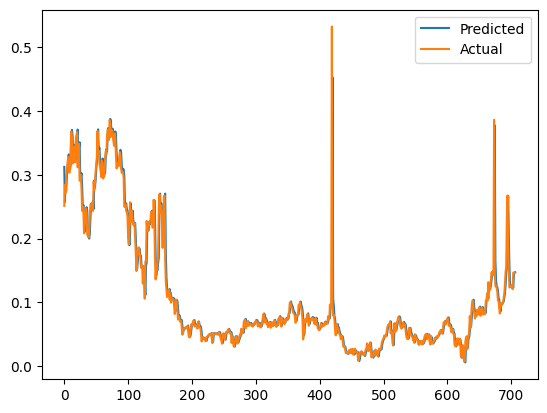

In [6]:
test_dataset = NGTimeSeries(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
test_preds = []
actuals = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.view(-1, Sequence_Length, 1)
        preds = model(inputs).view(-1)
        test_preds.append(preds.numpy())
        actuals.append(targets.numpy())

test_preds = np.array(test_preds).flatten()
actuals = np.array(actuals).flatten()

plt.plot(test_preds, label='Predicted')
plt.plot(actuals, label='Actual')
plt.legend()
plt.show()

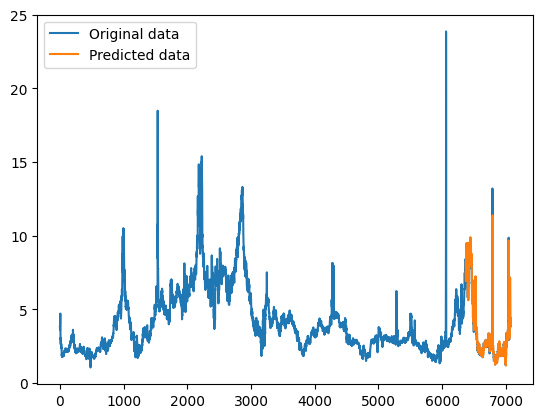

In [7]:
y = y * (maxm - minm) + minm
test_preds = test_preds * (maxm - minm) + minm


plt.plot(y, label='Original data')
plt.plot(range(len(y) - len(test_preds), len(y)), test_preds, label='Predicted data')
plt.legend()
plt.show()

## Q2

In [24]:
import os
import string
import torch
from torch.utils.data import Dataset, DataLoader


all_characters = string.ascii_letters + string.punctuation + " .,-'áéíóúäöüçñÁÉÍÓÚÀÈÙÖâêôàèîô" 
n_characters = len(all_characters)

char_to_index = {ch: i for i, ch in enumerate(all_characters)}
index_to_char = {i: ch for i, ch in enumerate(all_characters)}


def clean_name(name):
    return name.replace('\xa0', ' ')


def load_data(data_dir):
    languages = []
    names = []
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.txt'):
            language = filename.split('.')[0]
            with open(os.path.join(data_dir, filename), 'r') as f:
                for name in f:
                    languages.append(language)
                    names.append(clean_name(name.strip()))
    
    return names, languages

data_dir = './data/names'

names, languages = load_data(data_dir)

name_indices = [[char_to_index.get(ch, char_to_index[' ']) for ch in name] for name in names]  
language_indices = [language_to_index[lang] for lang in languages]


In [25]:
class NameDataset(Dataset):
    def __init__(self, name_indices, language_indices, max_name_length=20):
        self.name_indices = name_indices
        self.language_indices = language_indices
        self.max_name_length = max_name_length
    
    def __len__(self):
        return len(self.name_indices)
    
    def __getitem__(self, idx):
        name = self.name_indices[idx]
        language = self.language_indices[idx]
        
        # Pad the name to make it the same length
        padded_name = name + [0] * (self.max_name_length - len(name)) if len(name) < self.max_name_length else name[:self.max_name_length]
        
        return torch.tensor(padded_name), torch.tensor(language)

# Instantiate dataset and dataloaders
dataset = NameDataset(name_indices, language_indices)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [34]:
class RNNModel(torch.nn.Module):
    def __init__(self, n_characters, hidden_size, n_languages):
        super(RNNModel, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.RNN(input_size=n_characters, hidden_size=hidden_size, batch_first=True)
        
        self.fc = torch.nn.Linear(hidden_size, n_languages)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        
        last_hidden_state = rnn_out[:, -1, :]
        
        out = self.fc(last_hidden_state)
        
        return out

In [36]:
model = RNNModel(n_characters, hidden_size=128, n_languages=len(languages_set))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for names, languages in train_loader:
        input_data = torch.zeros(names.size(0), names.size(1), n_characters)
        for i, name in enumerate(names):
            for j, char_index in enumerate(name):
                input_data[i, j, char_index] = 1 
        
        outputs = model(input_data)
        
        loss = criterion(outputs, languages)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == languages).sum().item()
        total_preds += languages.size(0)
        
        running_loss += loss.item()
    
    accuracy = correct_preds / total_preds
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy*100}%")


Epoch 1/10, Loss: 1.995155471145727, Accuracy: 44.1566205041347%
Epoch 2/10, Loss: 1.844537447212608, Accuracy: 46.86659360366644%
Epoch 3/10, Loss: 1.8448122329772658, Accuracy: 46.86659360366644%
Epoch 4/10, Loss: 1.8445391863774343, Accuracy: 46.86659360366644%
Epoch 5/10, Loss: 1.8454191460730924, Accuracy: 46.86659360366644%
Epoch 6/10, Loss: 1.8447069286540816, Accuracy: 46.86659360366644%
Epoch 7/10, Loss: 1.8452645813583568, Accuracy: 46.86659360366644%
Epoch 8/10, Loss: 1.8449991709867102, Accuracy: 46.86659360366644%
Epoch 9/10, Loss: 1.845149747884957, Accuracy: 46.86659360366644%
Epoch 10/10, Loss: 1.8452761518727443, Accuracy: 46.86659360366644%


## Q3

In [1]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('./data/text.txt', 'r') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}

text_as_indices = [char_to_idx[ch] for ch in text]

sequence_length = 100 

input_sequences = []
output_characters = []

for i in range(len(text_as_indices) - sequence_length):
    input_sequences.append(text_as_indices[i:i+sequence_length])
    output_characters.append(text_as_indices[i+sequence_length])

X = np.array(input_sequences)
Y = np.array(output_characters)

X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [2]:
class RNNNextCharModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, sequence_length):
        super(RNNNextCharModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size) 
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)  
    
    def forward(self, x):
        x = self.embedding(x)
        
        out, _ = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        return out


In [3]:
model = RNNNextCharModel(vocab_size, embed_size=128, hidden_size=256, sequence_length=sequence_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, Y_batch in dataloader:

        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        
        output = model(X_batch)
        
        loss = criterion(output, Y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/5, Loss: 2.0013
Epoch 2/5, Loss: 2.0657
Epoch 3/5, Loss: 2.0204
Epoch 4/5, Loss: 2.0217
Epoch 5/5, Loss: 2.0324


In [8]:
def generate_text(model, start_string, char_to_idx, idx_to_char, sequence_length=100, num_generate=100):
    model.eval()
    
    input_seq = [char_to_idx[ch] for ch in start_string]
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0)
    input_seq = input_seq.to(device)
    
    generated_text = start_string
    
    with torch.no_grad():
        for _ in range(num_generate):
            output = model(input_seq)
            predicted_idx = torch.argmax(output, dim=1).item()
            
            predicted_char = idx_to_char[predicted_idx]
            generated_text += predicted_char
            
            input_seq = torch.cat((input_seq[:, 1:], torch.tensor([[predicted_idx]], dtype=torch.long).to(device)), dim=1)
    
    return generated_text

start_string = "Every"
generated_text = generate_text(model, start_string, char_to_idx, idx_to_char, num_generate=500)
print(generated_text)


Every sur le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le 
